adapted from <https://developmentalsystems.org/sensorimotor-lenia/>


In [1]:
a, b, c, d = None, None, None, None


In [2]:
from copy import deepcopy
import numbers
import warnings

from addict import Dict
import numpy as np
import torch

torch.set_default_tensor_type("torch.FloatTensor")


In [3]:
import cv2


class VideoWriter:
    def __init__(self, filename, fps=30.0, fourcc="mp4v"):
        self.filename = filename
        self.fps = fps
        self.writer = None
        # Define the codec using OpenCV's VideoWriter_fourcc function.
        self.fourcc = cv2.VideoWriter_fourcc(*fourcc)

    def add(self, img):
        img = np.asarray(img)
        # Convert image from float to uint8 if needed.
        if img.dtype in [np.float32, np.float64]:
            img = np.uint8(np.clip(img, 0, 1) * 255)
        # If the image is grayscale, convert it to a 3-channel BGR image.
        if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        # Initialize the writer when the first frame is added.
        if self.writer is None:
            h, w = img.shape[:2]
            self.writer = cv2.VideoWriter(
                self.filename, self.fourcc, self.fps, (w, h)
            )
        self.writer.write(img)

    def close(self):
        if self.writer:
            self.writer.release()
            self.writer = None

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.close()

    def show(self, width=640, height=480):
        self.close()
        # Display the saved video in the notebook.
        print("bypassing output")


In [4]:
def complex_mult_torch(X, Y):
    """Computes the complex multiplication in Pytorch when the tensor last dimension is 2: 0 is the real component and 1 the imaginary one"""
    assert X.shape[-1] == 2 and Y.shape[-1] == 2, "Last dimension must be 2"
    return torch.stack(
        (
            X[..., 0] * Y[..., 0] - X[..., 1] * Y[..., 1],
            X[..., 0] * Y[..., 1] + X[..., 1] * Y[..., 0],
        ),
        dim=-1,
    )


def roll_n(X, axis, n):
    """Rolls a tensor with a shift n on the specified axis"""
    f_idx = tuple(
        slice(None, None, None) if i != axis else slice(0, n, None)
        for i in range(X.dim())
    )
    b_idx = tuple(
        slice(None, None, None) if i != axis else slice(n, None, None)
        for i in range(X.dim())
    )
    front = X[f_idx]
    back = X[b_idx]
    return torch.cat([back, front], axis)


In [5]:
class Space(object):
    """
    Defines the init_space, genome_space and intervention_space of a system
    """

    def __init__(self, shape=None, dtype=None):
        self.shape = None if shape is None else tuple(shape)
        self.dtype = dtype

    def sample(self):
        """
        Randomly sample an element of this space.
        Can be uniform or non-uniform sampling based on boundedness of space."""
        raise NotImplementedError

    def mutate(self, x):
        """
        Randomly mutate an element of this space.
        """
        raise NotImplementedError

    def contains(self, x):
        """
        Return boolean specifying if x is a valid
        member of this space
        """
        raise NotImplementedError

    def clamp(self, x):
        """
        Return a valid clamped value of x inside space's bounds
        """
        raise NotImplementedError

    def __contains__(self, x):
        return self.contains(x)


In [6]:
class DiscreteSpace(Space):
    r"""A discrete space in :math:`\{ 0, 1, \\dots, n-1 \}`.
    /!\ mutation is gaussian by default: please create custom space inheriting from discrete space for custom mutation functions

    Example::

        >>> DiscreteSpace(2)

    """

    def __init__(self, n, mutation_mean=0.0, mutation_std=1.0, indpb=1.0):
        assert n >= 0
        self.n = n

        # mutation_mean: mean for the gaussian addition mutation
        # mutation_std: std for the gaussian addition mutation
        # indpb – independent probability for each attribute to be mutated.
        self.mutation_mean = torch.as_tensor(
            mutation_mean, dtype=torch.float64
        )
        self.mutation_std = torch.as_tensor(mutation_std, dtype=torch.float64)
        self.indpb = torch.as_tensor(indpb, dtype=torch.float64)
        super(DiscreteSpace, self).__init__((), torch.int64)

    def sample(self):
        return torch.randint(self.n, ())

    def mutate(self, x):
        mutate_mask = torch.rand(self.shape) < self.indpb
        noise = torch.normal(self.mutation_mean, self.mutation_std, ())
        x = x.type(torch.float64) + mutate_mask * noise
        x = torch.floor(x).type(self.dtype)
        if not self.contains(x):
            return self.clamp(x)
        else:
            return x

    def contains(self, x):
        if isinstance(x, int):
            as_int = x
        elif not x.dtype.is_floating_point and (
            x.shape == ()
        ):  # integer or size 0
            as_int = int(x)
        else:
            return False
        return 0 <= as_int < self.n

    def clamp(self, x):
        x = torch.max(x, torch.as_tensor(0, dtype=self.dtype, device=x.device))
        x = torch.min(
            x, torch.as_tensor(self.n - 1, dtype=self.dtype, device=x.device)
        )
        return x

    def __repr__(self):
        return "DiscreteSpace(%d)" % self.n

    def __eq__(self, other):
        return isinstance(other, DiscreteSpace) and self.n == other.n


In [7]:
class BoxSpace(Space):
    """
    A (possibly unbounded) box in R^n. Specifically, a Box represents the
    Cartesian product of n closed intervals. Each interval has the form of one
    of [a, b], (-oo, b], [a, oo), or (-oo, oo).

    There are two common use cases:

    * Identical bound for each dimension::
        >>> BoxSpace(low=-1.0, high=2.0, shape=(3, 4), dtype=torch.float32)
        Box(3, 4)

    * Independent bound for each dimension::
        >>> BoxSpace(low=torch.tensor([-1.0, -2.0]), high=torch.tensor([2.0, 4.0]), dtype=torch.float32)
        Box(2,)

    """

    def __init__(
        self,
        low,
        high,
        shape=None,
        dtype=torch.float32,
        mutation_mean=0.0,
        mutation_std=1.0,
        indpb=1.0,
    ):
        assert dtype is not None, "dtype must be explicitly provided. "
        self.dtype = dtype

        # determine shape if it isn't provided directly
        if shape is not None:
            shape = tuple(shape)
            assert (
                isinstance(low, numbers.Number) or low.shape == shape
            ), "low.shape doesn't match provided shape"
            assert (
                isinstance(high, numbers.Number) or high.shape == shape
            ), "high.shape doesn't match provided shape"
        elif not isinstance(low, numbers.Number):
            shape = low.shape
            assert (
                isinstance(high, numbers.Number) or high.shape == shape
            ), "high.shape doesn't match low.shape"
        elif not isinstance(high, numbers.Number):
            shape = high.shape
            assert (
                isinstance(low, numbers.Number) or low.shape == shape
            ), "low.shape doesn't match high.shape"
        else:
            raise ValueError(
                "shape must be provided or inferred from the shapes of low or high"
            )

        if isinstance(low, numbers.Number):
            low = torch.full(shape, low, dtype=dtype)

        if isinstance(high, numbers.Number):
            high = torch.full(shape, high, dtype=dtype)

        self.shape = shape
        self.low = low.type(self.dtype)
        self.high = high.type(self.dtype)

        # Boolean arrays which indicate the interval type for each coordinate
        self.bounded_below = ~torch.isneginf(self.low)
        self.bounded_above = ~torch.isposinf(self.high)

        # mutation_mean: mean for the gaussian addition mutation
        # mutation_std: std for the gaussian addition mutation
        # indpb – independent probability for each attribute to be mutated.
        if isinstance(mutation_mean, numbers.Number):
            mutation_mean = torch.full(
                self.shape, mutation_mean, dtype=torch.float64
            )
        self.mutation_mean = torch.as_tensor(
            mutation_mean, dtype=torch.float64
        )
        if isinstance(mutation_std, numbers.Number):
            mutation_std = torch.full(
                self.shape, mutation_std, dtype=torch.float64
            )
        self.mutation_std = torch.as_tensor(mutation_std, dtype=torch.float64)
        if isinstance(indpb, numbers.Number):
            indpb = torch.full(self.shape, indpb, dtype=torch.float64)
        self.indpb = torch.as_tensor(indpb, dtype=torch.float64)

        super(BoxSpace, self).__init__(self.shape, self.dtype)

    def is_bounded(self, manner="both"):
        below = torch.all(self.bounded_below)
        above = torch.all(self.bounded_above)
        if manner == "both":
            return below and above
        elif manner == "below":
            return below
        elif manner == "above":
            return above
        else:
            raise ValueError("manner is not in {'below', 'above', 'both'}")

    def sample(self):
        """
        Generates a single random sample inside of the Box.

        In creating a sample of the box, each coordinate is sampled according to
        the form of the interval:

        * [a, b] : uniform distribution
        * [a, oo) : shifted exponential distribution
        * (-oo, b] : shifted negative exponential distribution
        * (-oo, oo) : normal distribution
        """
        high = (
            self.high.type(torch.float64)
            if self.dtype.is_floating_point
            else self.high.type(torch.int64) + 1
        )
        sample = torch.empty(self.shape, dtype=torch.float64)

        # Masking arrays which classify the coordinates according to interval
        # type
        unbounded = ~self.bounded_below & ~self.bounded_above
        upp_bounded = ~self.bounded_below & self.bounded_above
        low_bounded = self.bounded_below & ~self.bounded_above
        bounded = self.bounded_below & self.bounded_above

        # Vectorized sampling by interval type
        sample[unbounded] = torch.randn(
            unbounded[unbounded].shape, dtype=torch.float64
        )

        sample[low_bounded] = (
            -torch.rand(low_bounded[low_bounded].shape, dtype=torch.float64)
        ).exponential_() + self.low[low_bounded]

        sample[upp_bounded] = (
            self.high[upp_bounded]
            - (
                -torch.rand(
                    upp_bounded[upp_bounded].shape, dtype=torch.float64
                )
            ).exponential_()
        )

        sample[bounded] = (self.low[bounded] - high[bounded]) * torch.rand(
            bounded[bounded].shape, dtype=torch.float64
        ) + high[bounded]

        if not self.dtype.is_floating_point:  # integer
            sample = torch.floor(sample)

        return sample.type(self.dtype)

    def mutate(self, x, mask=None):
        if mask is None:
            mask = torch.ones(x.shape).to(x.device)

        mutate_mask = mask * (
            (torch.rand(self.shape) < self.indpb).type(torch.float64)
        ).to(x.device)
        noise = torch.normal(self.mutation_mean, self.mutation_std).to(
            x.device
        )
        x = x.type(torch.float64) + mutate_mask * noise
        if not self.dtype.is_floating_point:  # integer
            x = torch.floor(x)
        x = x.type(self.dtype)
        if not self.contains(x):
            return self.clamp(x)
        else:
            return x

    def contains(self, x):
        if isinstance(x, list):
            x = torch.tensor(x)  # Promote list to array for contains check
        return (
            x.shape == self.shape
            and torch.all(
                x
                >= torch.as_tensor(self.low, dtype=self.dtype, device=x.device)
            )
            and torch.all(
                x
                <= torch.as_tensor(
                    self.high, dtype=self.dtype, device=x.device
                )
            )
        )

    def clamp(self, x):
        if self.is_bounded(manner="below"):
            x = torch.max(
                x, torch.as_tensor(self.low, dtype=self.dtype, device=x.device)
            )
        if self.is_bounded(manner="above"):
            x = torch.min(
                x,
                torch.as_tensor(self.high, dtype=self.dtype, device=x.device),
            )
        return x

    def __repr__(self):
        return "BoxSpace({}, {}, {}, {})".format(
            self.low.min(), self.high.max(), self.shape, self.dtype
        )

    def __eq__(self, other):
        return (
            isinstance(other, BoxSpace)
            and (self.shape == other.shape)
            and torch.allclose(self.low, other.low)
            and torch.allclose(self.high, other.high)
        )


In [8]:
class DictSpace(Space):
    """
    A Dict dictionary of simpler spaces.

    Example usage:
    self.genome_space = spaces.DictSpace({"position": spaces.Discrete(2), "velocity": spaces.Discrete(3)})

    Example usage [nested]:
    self.nested_genome_space = spaces.DictSpace({
        'sensors':  spaces.DictSpace({
            'position': spaces.Box(low=-100, high=100, shape=(3,)),
            'velocity': spaces.Box(low=-1, high=1, shape=(3,)),
            'front_cam': spaces.Tuple((
                spaces.Box(low=0, high=1, shape=(10, 10, 3)),
                spaces.Box(low=0, high=1, shape=(10, 10, 3))
            )),
            'rear_cam': spaces.Box(low=0, high=1, shape=(10, 10, 3)),
        }),
        'ext_controller': spaces.MultiDiscrete((5, 2, 2)),
        'inner_state':spaces.DictSpace({
            'charge': spaces.Discrete(100),
            'system_checks': spaces.MultiBinary(10),
            'job_status': spaces.DictSpace({
                'task': spaces.Discrete(5),
                'progress': spaces.Box(low=0, high=100, shape=()),
            })
        })
    })
    """

    def __init__(self, spaces=None, **spaces_kwargs):
        assert (spaces is None) or (
            not spaces_kwargs
        ), "Use either DictSpace(spaces=dict(...)) or DictSpace(foo=x, bar=z)"
        if spaces is None:
            spaces = spaces_kwargs
        if isinstance(spaces, list):
            spaces = Dict(spaces)
        self.spaces = spaces
        for space in spaces.values():
            assert isinstance(
                space, Space
            ), "Values of the attrdict should be instances of gym.Space"
        Space.__init__(
            self, None, None
        )  # None for shape and dtype, since it'll require special handling

    def sample(self):
        return Dict([(k, space.sample()) for k, space in self.spaces.items()])

    def mutate(self, x):
        return Dict(
            [(k, space.mutate(x[k])) for k, space in self.spaces.items()]
        )

    def contains(self, x):
        if not isinstance(x, dict) or len(x) != len(self.spaces):
            return False
        for k, space in self.spaces.items():
            if k not in x:
                return False
            if not space.contains(x[k]):
                return False
        return True

    def clamp(self, x):
        return Dict(
            [(k, space.clamp(x[k])) for k, space in self.spaces.items()]
        )

    def __getitem__(self, key):
        return self.spaces[key]

    def __iter__(self):
        for key in self.spaces:
            yield key

    def __repr__(self):
        return (
            "DictSpace("
            + ", ".join(
                [str(k) + ":" + str(s) for k, s in self.spaces.items()]
            )
            + ")"
        )

    def __eq__(self, other):
        return isinstance(other, DictSpace) and self.spaces == other.spaces


In [9]:
class MultiDiscreteSpace(Space):
    """
    - The multi-discrete space consists of a series of discrete spaces with different number of possible instances in eachs
    - Can be initialized as

        MultiDiscreteSpace([ 5, 2, 2 ])

    """

    def __init__(self, nvec, mutation_mean=0.0, mutation_std=1.0, indpb=1.0):
        """
        nvec: vector of counts of each categorical variable
        """
        assert (
            torch.tensor(nvec) > 0
        ).all(), "nvec (counts) have to be positive"
        self.nvec = torch.as_tensor(nvec, dtype=torch.int64)
        self.mutation_std = mutation_std

        # mutation_mean: mean for the gaussian addition mutation
        # mutation_std: std for the gaussian addition mutation
        # indpb – independent probability for each attribute to be mutated.
        if isinstance(mutation_mean, numbers.Number):
            mutation_mean = torch.full(
                self.nvec.shape, mutation_mean, dtype=torch.float64
            )
        self.mutation_mean = torch.as_tensor(
            mutation_mean, dtype=torch.float64
        )
        if isinstance(mutation_std, numbers.Number):
            mutation_std = torch.full(
                self.nvec.shape, mutation_std, dtype=torch.float64
            )
        self.mutation_std = torch.as_tensor(mutation_std, dtype=torch.float64)
        if isinstance(indpb, numbers.Number):
            indpb = torch.full(self.nvec.shape, indpb, dtype=torch.float64)
        self.indpb = torch.as_tensor(indpb, dtype=torch.float64)

        super(MultiDiscreteSpace, self).__init__(self.nvec.shape, torch.int64)

    def sample(self):
        return (torch.rand(self.nvec.shape) * self.nvec).type(self.dtype)

    def mutate(self, x):
        mutate_mask = (torch.rand(self.shape) < self.indpb).to(x.device)
        noise = torch.normal(self.mutation_mean, self.mutation_std).to(
            x.device
        )
        x = x.type(torch.float64) + mutate_mask * noise
        x = torch.floor(x).type(self.dtype)
        if not self.contains(x):
            return self.clamp(x)
        else:
            return x

    def contains(self, x):
        if isinstance(x, list):
            x = torch.tensor(x)  # Promote list to array for contains check
        # if nvec is uint32 and space dtype is uint32, then 0 <= x < self.nvec guarantees that x
        # is within correct bounds for space dtype (even though x does not have to be unsigned)
        return (
            x.shape == self.shape and (0 <= x).all() and (x < self.nvec).all()
        )

    def clamp(self, x):
        x = torch.max(x, torch.as_tensor(0, dtype=self.dtype, device=x.device))
        x = torch.min(
            x,
            torch.as_tensor(self.nvec - 1, dtype=self.dtype, device=x.device),
        )
        return x

    def __repr__(self):
        return "MultiDiscreteSpace({})".format(self.nvec)

    def __eq__(self, other):
        return isinstance(other, MultiDiscreteSpace) and torch.all(
            self.nvec == other.nvec
        )


In [10]:
class BoxGoalSpace(BoxSpace):
    def __init__(
        self,
        representation,
        autoexpand=True,
        low=0.0,
        high=0.0,
        shape=None,
        dtype=torch.float32,
    ):
        self.representation = representation
        self.autoexpand = autoexpand
        if shape is not None:
            if isinstance(shape, list) or isinstance(shape, tuple):
                assert (
                    len(shape) == 1
                    and shape[0] == self.representation.n_latents
                )
            elif isinstance(shape, numbers.Number):
                assert shape == self.representation.n_latents
        BoxSpace.__init__(
            self,
            low=low,
            high=high,
            shape=(self.representation.n_latents,),
            dtype=dtype,
        )

    def map(self, observations, **kwargs):
        embedding = self.representation.calc(observations, **kwargs)
        if self.autoexpand:
            embedding_c = embedding.detach()
            is_nan_mask = torch.isnan(embedding_c)
            if is_nan_mask.sum() > 0:
                embedding_c[is_nan_mask] = self.low[is_nan_mask]
                self.low = torch.min(self.low, embedding_c)
                embedding_c[is_nan_mask] = self.high[is_nan_mask]
                self.high = torch.max(self.high, embedding_c)
            else:
                self.low = torch.min(self.low, embedding_c)
                self.high = torch.max(self.high, embedding_c)
        return embedding

    def calc_distance(self, embedding_a, embedding_b, **kwargs):
        return self.representation.calc_distance(
            embedding_a, embedding_b, **kwargs
        )

    def sample(self):
        return BoxSpace.sample(self)


In [11]:
class LeniaInitializationSpace(DictSpace):
    """Class for initialization space that allows to sample and clip the initialization"""

    @staticmethod
    def default_config():
        default_config = Dict()
        default_config.neat_config = None
        default_config.cppn_n_passes = 2
        return default_config

    def __init__(self, init_size=40, config={}, **kwargs):
        self.config = self.__class__.default_config()
        self.config.update(config)
        self.config.update(kwargs)

        spaces = Dict(
            # cppn_genome = LeniaCPPNInitSpace(self.config)
            init=BoxSpace(
                low=0.0,
                high=1.0,
                shape=(init_size, init_size),
                mutation_mean=torch.zeros((40, 40)),
                mutation_std=torch.ones((40, 40)) * 0.01,
                indpb=0.0,
                dtype=torch.float32,
            )
        )

        DictSpace.__init__(self, spaces=spaces)


""" =============================================================================================
Lenia Update Rule Space:
============================================================================================= """


class LeniaUpdateRuleSpace(DictSpace):
    """Space associated to the parameters of the update rule"""

    @staticmethod
    def default_config():
        default_config = Dict()
        return default_config

    def __init__(self, nb_k=10, config={}, **kwargs):
        self.config = self.__class__.default_config()
        self.config.update(config)
        self.config.update(kwargs)

        spaces = Dict(
            R=DiscreteSpace(
                n=25, mutation_mean=0.0, mutation_std=0.01, indpb=0.01
            ),
            c0=MultiDiscreteSpace(
                nvec=[1] * nb_k,
                mutation_mean=torch.zeros((nb_k,)),
                mutation_std=0.1 * torch.ones((nb_k,)),
                indpb=0.1,
            ),
            c1=MultiDiscreteSpace(
                nvec=[1] * nb_k,
                mutation_mean=torch.zeros((nb_k,)),
                mutation_std=0.1 * torch.ones((nb_k,)),
                indpb=0.1,
            ),
            T=BoxSpace(
                low=1.0,
                high=10.0,
                shape=(),
                mutation_mean=0.0,
                mutation_std=0.1,
                indpb=0.01,
                dtype=torch.float32,
            ),
            rk=BoxSpace(
                low=0,
                high=1,
                shape=(nb_k, 3),
                mutation_mean=torch.zeros((nb_k, 3)),
                mutation_std=0.2 * torch.ones((nb_k, 3)),
                indpb=1,
                dtype=torch.float32,
            ),
            b=BoxSpace(
                low=0.0,
                high=1.0,
                shape=(nb_k, 3),
                mutation_mean=torch.zeros((nb_k, 3)),
                mutation_std=0.2 * torch.ones((nb_k, 3)),
                indpb=1,
                dtype=torch.float32,
            ),
            w=BoxSpace(
                low=0.01,
                high=0.5,
                shape=(nb_k, 3),
                mutation_mean=torch.zeros((nb_k, 3)),
                mutation_std=0.2 * torch.ones((nb_k, 3)),
                indpb=1,
                dtype=torch.float32,
            ),
            m=BoxSpace(
                low=0.05,
                high=0.5,
                shape=(nb_k,),
                mutation_mean=torch.zeros((nb_k,)),
                mutation_std=0.2 * torch.ones((nb_k,)),
                indpb=1,
                dtype=torch.float32,
            ),
            s=BoxSpace(
                low=0.001,
                high=0.18,
                shape=(nb_k,),
                mutation_mean=torch.zeros((nb_k,)),
                mutation_std=0.01 ** torch.ones((nb_k,)),
                indpb=0.1,
                dtype=torch.float32,
            ),
            h=BoxSpace(
                low=0,
                high=1.0,
                shape=(nb_k,),
                mutation_mean=torch.zeros((nb_k,)),
                mutation_std=0.2 * torch.ones((nb_k,)),
                indpb=0.1,
                dtype=torch.float32,
            ),
            r=BoxSpace(
                low=0.2,
                high=1.0,
                shape=(nb_k,),
                mutation_mean=torch.zeros((nb_k,)),
                mutation_std=0.2 * torch.ones((nb_k,)),
                indpb=1,
                dtype=torch.float32,
            )
            # kn = DiscreteSpace(n=4, mutation_mean=0.0, mutation_std=0.1, indpb=1.0),
            # gn = DiscreteSpace(n=3, mutation_mean=0.0, mutation_std=0.1, indpb=1.0),
        )

        DictSpace.__init__(self, spaces=spaces)

    def mutate(self, x):
        mask = (x["s"] > 0.04).float() * (
            torch.rand(x["s"].shape[0]) < 0.25
        ).float().to(x["s"].device)
        param = []
        for k, space in self.spaces.items():
            if k == "R" or k == "c0" or k == "c1" or k == "T":
                param.append((k, space.mutate(x[k])))
            elif k == "rk" or k == "w" or k == "b":
                param.append((k, space.mutate(x[k], mask.unsqueeze(-1))))
            else:
                param.append((k, space.mutate(x[k], mask)))

        return Dict(param)


""" =============================================================================================
Lenia Main
============================================================================================= """


def bell(x, m, s):
    return torch.exp(-(((x - m) / s) ** 2) / 2)


# Lenia family of functions for the kernel K and for the growth mapping g
kernel_core = {
    0: lambda u: (4 * u * (1 - u)) ** 4,  # polynomial (quad4)
    1: lambda u: torch.exp(
        4 - 1 / (u * (1 - u))
    ),  # exponential / gaussian bump (bump4)
    2: lambda u, q=1 / 4: (u >= q).float()
    * (u <= 1 - q).float(),  # step (stpz1/4)
    3: lambda u, q=1 / 4: (u >= q).float() * (u <= 1 - q).float()
    + (u < q).float() * 0.5,  # staircase (life)
    4: lambda u: torch.exp(-((u - 0.5) ** 2) / 0.2),
    8: lambda u: (torch.sin(10 * u) + 1) / 2,
    9: lambda u: (a * torch.sin((u.unsqueeze(-1) * 5 * b + c) * np.pi)).sum(-1)
    / (2 * a.sum())
    + 1 / 2,
}
field_func = {
    0: lambda n, m, s: torch.max(
        torch.zeros_like(n), 1 - (n - m) ** 2 / (9 * s**2)
    )
    ** 4
    * 2
    - 1,  # polynomial (quad4)
    1: lambda n, m, s: torch.exp(-((n - m) ** 2) / (2 * s**2) - 1e-3) * 2
    - 1,  # exponential / gaussian (gaus)
    2: lambda n, m, s: (torch.abs(n - m) <= s).float() * 2 - 1,  # step (stpz)
    3: lambda n, m, s: -torch.clamp(n - m, 0, 1) * s,  # food eating kernl
}

# ker_c =lambda r,a,b,c :(a*torch.sin((r.unsqueeze(-1)*5*b+c)*np.pi)).sum(-1)/(2*a.sum())+1/2
def ker_c(x, r, w, b):
    return (b * torch.exp(-(((x.unsqueeze(-1) - r) / w) ** 2) / 2)).sum(-1)


class Dummy_init_mod(torch.nn.Module):
    def __init__(self, init):
        torch.nn.Module.__init__(self)
        self.register_parameter("init", torch.nn.Parameter(init))


# Lenia Step FFT version (faster)
class LeniaStepFFTC(torch.nn.Module):
    """Module pytorch that computes one Lenia Step with the fft version"""

    def __init__(
        self,
        C,
        R,
        T,
        c0,
        c1,
        r,
        rk,
        b,
        w,
        h,
        m,
        s,
        gn,
        is_soft_clip=False,
        SX=256,
        SY=256,
        speed_x=0,
        speed_y=0,
        device="cpu",
    ):
        torch.nn.Module.__init__(self)

        self.register_buffer("R", R)
        self.register_buffer("T", T)
        self.register_buffer("c0", c0)
        self.register_buffer("c1", c1)
        # self.register_buffer('r', r)
        self.register_parameter("r", torch.nn.Parameter(r))
        self.register_parameter("rk", torch.nn.Parameter(rk))
        self.register_parameter("b", torch.nn.Parameter(b))
        self.register_parameter("w", torch.nn.Parameter(w))
        self.register_parameter("h", torch.nn.Parameter(h))
        self.register_parameter("m", torch.nn.Parameter(m))
        self.register_parameter("s", torch.nn.Parameter(s))
        self.speed_x = speed_x
        self.speed_y = speed_y

        self.gn = 1
        self.nb_k = c0.shape[0]

        self.SX = SX
        self.SY = SY

        self.is_soft_clip = is_soft_clip
        self.C = C

        self.device = device
        self.to(device)
        self.kernels = torch.zeros((self.nb_k, self.SX, self.SY, 2)).to(
            self.device
        )

        self.compute_kernel()
        self.compute_kernel_env()

    def compute_kernel_env(self):
        """computes the kernel and the kernel FFT of the environnement from the parameters"""
        x = torch.arange(self.SX).to(self.device)
        y = torch.arange(self.SY).to(self.device)
        xx = x.view(-1, 1).repeat(1, self.SY)
        yy = y.repeat(self.SX, 1)
        X = (xx - int(self.SX / 2)).float()
        Y = (yy - int(self.SY / 2)).float()
        D = torch.sqrt(X**2 + Y**2) / (4)
        kernel = torch.sigmoid(-(D - 1) * 10) * ker_c(
            D,
            torch.tensor(np.array([0, 0, 0])).to(self.device),
            torch.tensor(np.array([0.5, 0.1, 0.1])).to(self.device),
            torch.tensor(np.array([1, 0, 0])).to(self.device),
        )
        kernel_sum = torch.sum(kernel)
        kernel_norm = kernel / kernel_sum
        # kernel_FFT = torch.rfft(kernel_norm, signal_ndim=2, onesided=False).to(self.device)
        kernel_FFT = torch.fft.rfftn(kernel_norm, dim=(0, 1)).to(self.device)

        self.kernel_wall = kernel_FFT

    def compute_kernel(self):
        """computes the kernel and the kernel FFT of the learnable channels from the parameters"""
        x = torch.arange(self.SX).to(self.device)
        y = torch.arange(self.SY).to(self.device)
        xx = x.view(-1, 1).repeat(1, self.SY)
        yy = y.repeat(self.SX, 1)
        X = (xx - int(self.SX / 2)).float()
        Y = (yy - int(self.SY / 2)).float()
        self.kernels = torch.zeros((self.nb_k, self.SX, self.SY // 2 + 1)).to(
            self.device
        )

        for i in range(self.nb_k):
            # distance to center in normalized space
            D = torch.sqrt(X**2 + Y**2) / ((self.R + 15) * self.r[i])

            kernel = torch.sigmoid(-(D - 1) * 10) * ker_c(
                D, self.rk[i], self.w[i], self.b[i]
            )
            kernel_sum = torch.sum(kernel)

            # normalization of the kernel
            kernel_norm = kernel / kernel_sum
            # plt.imshow(kernel_norm[0,0].detach().cpu()*100)
            # plt.show()

            # fft of the kernel
            # kernel_FFT = torch.rfft(kernel_norm, signal_ndim=2, onesided=False).to(self.device)
            kernel_FFT = torch.fft.rfftn(kernel_norm, dim=(0, 1)).to(
                self.device
            )

            self.kernels[i] = kernel_FFT

    def forward(self, input):
        input[:, :, :, 1] = torch.roll(
            input[:, :, :, 1], [self.speed_y, self.speed_x], [1, 2]
        )
        self.D = torch.zeros(input.shape).to(self.device)
        self.Dn = torch.zeros(self.C)

        # world_FFT = [torch.rfft(input[:,:,:,i], signal_ndim=2, onesided=False) for i in range(self.C)]
        world_FFT = [
            torch.fft.rfftn(input[:, :, :, i], dim=(1, 2))
            for i in range(self.C)
        ]

        ## speed up of the update for 1 channel creature by multiplying by all the kernel FFT

        # channel 0 is the learnable channel
        world_FFT_c = world_FFT[0]
        # multiply the FFT of the world and the kernels
        potential_FFT = self.kernels * world_FFT_c
        # ifft + realignself.SY//2+1
        potential = torch.fft.irfftn(potential_FFT, dim=(1, 2))
        potential = roll_n(potential, 2, potential.size(2) // 2)
        potential = roll_n(potential, 1, potential.size(1) // 2)
        # growth function
        gfunc = field_func[min(self.gn, 3)]
        field = gfunc(
            potential,
            self.m.unsqueeze(-1).unsqueeze(-1),
            self.s.unsqueeze(-1).unsqueeze(-1),
        )
        # add the growth multiplied by the weight of the rule to the total growth
        self.D[:, :, :, 0] = (self.h.unsqueeze(-1).unsqueeze(-1) * field).sum(
            0, keepdim=True
        )
        self.Dn[0] = self.h.sum()

        ###Base version for the case where we want the learnable creature to be  multi channel (which is not used in this notebook)

        # for i in range(self.nb_k):
        #   c0b=int((self.c0[i]))
        #   c1b=int((self.c1[i]))

        #   world_FFT_c = world_FFT[c0b]
        #   potential_FFT = complex_mult_torch(self.kernels[i].unsqueeze(0), world_FFT_c)

        #   potential = torch.irfft(potential_FFT, signal_ndim=2, onesided=False)
        #   potential = roll_n(potential, 2, potential.size(2) // 2)
        #   potential = roll_n(potential, 1, potential.size(1) // 2)

        #   gfunc = field_func[min(self.gn, 3)]
        #   field = gfunc(potential, self.m[i], self.s[i])

        #   self.D[:,:,:,c1b]=self.D[:,:,:,c1b]+self.h[i]*field
        #   self.Dn[c1b]=self.Dn[c1b]+self.h[i]

        # apply wall
        world_FFT_c = world_FFT[self.C - 1]
        potential_FFT = self.kernel_wall * world_FFT_c
        potential = torch.fft.irfftn(potential_FFT, dim=(1, 2))
        potential = roll_n(potential, 2, potential.size(2) // 2)
        potential = roll_n(potential, 1, potential.size(1) // 2)
        gfunc = field_func[3]
        field = gfunc(potential, 1e-8, 10)
        for i in range(self.C - 1):
            c1b = i
            self.D[:, :, :, c1b] = self.D[:, :, :, c1b] + 1 * field
            self.Dn[c1b] = self.Dn[c1b] + 1

        ## Add the total growth to the current state
        if not self.is_soft_clip:

            output_img = torch.clamp(
                input + (1.0 / self.T) * self.D, min=0.0, max=1.0
            )
            # output_img = input + (1.0 / self.T) * ((self.D/self.Dn+1)/2-input)

        else:
            output_img = torch.sigmoid(
                (input + (1.0 / self.T) * self.D - 0.5) * 10
            )
            # output_img = torch.tanh(input + (1.0 / self.T) * self.D)

        return output_img


class Lenia_C(torch.nn.Module):
    @staticmethod
    def default_config():
        default_config = Dict()
        default_config.version = (
            "pytorch_fft"  # "pytorch_fft", "pytorch_conv2d"
        )
        default_config.SX = 256
        default_config.SY = 256
        default_config.final_step = 40
        default_config.C = 2
        default_config.speed_x = 0
        default_config.speed_y = 0
        return default_config

    def __init__(
        self,
        initialization_space=None,
        update_rule_space=None,
        nb_k=10,
        init_size=40,
        config={},
        device=torch.device("cpu"),
        **kwargs,
    ):
        self.config = self.__class__.default_config()
        self.config.update(config)
        self.config.update(kwargs)
        torch.nn.Module.__init__(self)
        self.device = device
        self.init_size = init_size
        if initialization_space is not None:
            self.initialization_space = initialization_space
        else:
            self.initialization_space = LeniaInitializationSpace(
                self.init_size
            )

        if update_rule_space is not None:
            self.update_rule_space = update_rule_space
        else:
            self.update_rule_space = LeniaUpdateRuleSpace(nb_k)

        self.run_idx = 0
        self.init_wall = torch.zeros((self.config.SX, self.config.SY))
        # reset with no argument to sample random parameters
        self.reset()
        self.to(self.device)

    def reset(
        self, initialization_parameters=None, update_rule_parameters=None
    ):
        # call the property setters
        if initialization_parameters is not None:
            self.initialization_parameters = initialization_parameters
        else:
            self.initialization_parameters = self.initialization_space.sample()

        if update_rule_parameters is not None:
            self.update_rule_parameters = update_rule_parameters
        else:
            policy_parameters = Dict.fromkeys(["update_rule"])
            policy_parameters["update_rule"] = self.update_rule_space.sample()
            # divide h by 3 at the beginning as some unbalanced kernels can easily kill
            policy_parameters["update_rule"].h = (
                policy_parameters["update_rule"].h / 3
            )
            self.update_rule_parameters = policy_parameters["update_rule"]

        # initialize Lenia CA with update rule parameters
        if self.config.version == "pytorch_fft":
            lenia_step = LeniaStepFFTC(
                self.config.C,
                self.update_rule_parameters["R"],
                self.update_rule_parameters["T"],
                self.update_rule_parameters["c0"],
                self.update_rule_parameters["c1"],
                self.update_rule_parameters["r"],
                self.update_rule_parameters["rk"],
                self.update_rule_parameters["b"],
                self.update_rule_parameters["w"],
                self.update_rule_parameters["h"],
                self.update_rule_parameters["m"],
                self.update_rule_parameters["s"],
                1,
                is_soft_clip=False,
                SX=self.config.SX,
                SY=self.config.SY,
                speed_x=self.config.speed_x,
                speed_y=self.config.speed_y,
                device=self.device,
            )
        self.add_module("lenia_step", lenia_step)

        # initialize Lenia initial state with initialization_parameters
        init = self.initialization_parameters["init"]
        # initialization_cppn = pytorchneat.rnn.RecurrentNetwork.create(cppn_genome, self.initialization_space.config.neat_config, device=self.device)
        self.add_module("initialization", Dummy_init_mod(init))

        # push the nn.Module and the available device
        self.to(self.device)
        self.generate_init_state()

    def random_obstacle(self, nb_obstacle=6):
        self.init_wall = torch.zeros((self.config.SX, self.config.SY))

        x = torch.arange(self.config.SX)
        y = torch.arange(self.config.SY)
        xx = x.view(-1, 1).repeat(1, self.config.SY)
        yy = y.repeat(self.config.SX, 1)
        for i in range(nb_obstacle):
            X = (xx - int(torch.rand(1) * self.config.SX)).float()
            Y = (yy - int(torch.rand(1) * self.config.SY / 2)).float()
            D = torch.sqrt(X**2 + Y**2) / 10
            mask = (D < 1).float()
            self.init_wall = torch.clamp(self.init_wall + mask, 0, 1)

    def random_obstacle_bis(self, nb_obstacle=6):
        self.init_wall = torch.zeros((self.config.SX, self.config.SY))

        x = torch.arange(self.config.SX)
        y = torch.arange(self.config.SY)
        xx = x.view(-1, 1).repeat(1, self.config.SY)
        yy = y.repeat(self.config.SX, 1)
        for i in range(nb_obstacle):
            X = (xx - int(torch.rand(1) * self.config.SX)).float()
            Y = (yy - int(torch.rand(1) * self.config.SY)).float()
            D = torch.sqrt(X**2 + Y**2) / 10
            mask = (D < 1).float()
            self.init_wall = torch.clamp(self.init_wall + mask, 0, 1)
        self.init_wall[95:155, 170:230] = 0

    def generate_init_state(self, X=105, Y=180):
        init_state = torch.zeros(
            1,
            self.config.SX,
            self.config.SY,
            self.config.C,
            dtype=torch.float64,
        )
        init_state[
            0, X : X + self.init_size, Y : Y + self.init_size, 0
        ] = self.initialization.init
        if self.config.C > 1:
            init_state[0, :, :, 1] = self.init_wall
        self.state = init_state.to(self.device)
        self.step_idx = 0

    def update_initialization_parameters(self):
        new_initialization_parameters = deepcopy(
            self.initialization_parameters
        )
        new_initialization_parameters["init"] = self.initialization.init.data
        if not self.initialization_space.contains(
            new_initialization_parameters
        ):
            new_initialization_parameters = self.initialization_space.clamp(
                new_initialization_parameters
            )
            warnings.warn(
                "provided parameters are not in the space range and are therefore clamped"
            )
        self.initialization_parameters = new_initialization_parameters

    def update_update_rule_parameters(self):
        new_update_rule_parameters = deepcopy(self.update_rule_parameters)
        # gather the parameter from the lenia step (which may have been optimized)
        new_update_rule_parameters["m"] = self.lenia_step.m.data
        new_update_rule_parameters["s"] = self.lenia_step.s.data
        new_update_rule_parameters["r"] = self.lenia_step.r.data
        new_update_rule_parameters["rk"] = self.lenia_step.rk.data
        new_update_rule_parameters["b"] = self.lenia_step.b.data
        new_update_rule_parameters["w"] = self.lenia_step.w.data
        new_update_rule_parameters["h"] = self.lenia_step.h.data
        if not self.update_rule_space.contains(new_update_rule_parameters):
            new_update_rule_parameters = self.update_rule_space.clamp(
                new_update_rule_parameters
            )
            warnings.warn(
                "provided parameters are not in the space range and are therefore clamped"
            )
        self.update_rule_parameters = new_update_rule_parameters

    def step(self, intervention_parameters=None):
        self.state = self.lenia_step(self.state)
        self.step_idx += 1
        return self.state

    def forward(self):
        state = self.step(None)
        return state

    def run(self):
        """run lenia for the number of step specified in the config.
        Returns the observations containing the state at each timestep"""
        # clip parameters just in case
        if not self.initialization_space["init"].contains(
            self.initialization.init.data
        ):
            self.initialization.init.data = self.initialization_space[
                "init"
            ].clamp(self.initialization.init.data)
        if not self.update_rule_space["r"].contains(self.lenia_step.r.data):
            self.lenia_step.r.data = self.update_rule_space["r"].clamp(
                self.lenia_step.r.data
            )
        if not self.update_rule_space["rk"].contains(self.lenia_step.rk.data):
            self.lenia_step.rk.data = self.update_rule_space["rk"].clamp(
                self.lenia_step.rk.data
            )
        if not self.update_rule_space["b"].contains(self.lenia_step.b.data):
            self.lenia_step.b.data = self.update_rule_space["b"].clamp(
                self.lenia_step.b.data
            )
        if not self.update_rule_space["w"].contains(self.lenia_step.w.data):
            self.lenia_step.w.data = self.update_rule_space["w"].clamp(
                self.lenia_step.w.data
            )
        if not self.update_rule_space["h"].contains(self.lenia_step.h.data):
            self.lenia_step.h.data = self.update_rule_space["h"].clamp(
                self.lenia_step.h.data
            )
        if not self.update_rule_space["m"].contains(self.lenia_step.m.data):
            self.lenia_step.m.data = self.update_rule_space["m"].clamp(
                self.lenia_step.m.data
            )
        if not self.update_rule_space["s"].contains(self.lenia_step.s.data):
            self.lenia_step.s.data = self.update_rule_space["s"].clamp(
                self.lenia_step.s.data
            )
        # self.generate_init_state()
        observations = Dict()
        observations.timepoints = list(range(self.config.final_step))
        observations.states = torch.empty(
            (
                self.config.final_step,
                self.config.SX,
                self.config.SY,
                self.config.C,
            )
        )
        observations.states[0] = self.state
        for step_idx in range(1, self.config.final_step):
            cur_observation = self.step(None)
            observations.states[step_idx] = cur_observation[0, :, :, :]

        return observations

    def save(self, filepath):
        """
        Saves the system object using torch.save function in pickle format
        Can be used if the system state's change over exploration and we want to dump it
        """
        torch.save(self, filepath)

    def close(self):
        pass


In [12]:
system = Lenia_C(nb_k=5)
system.config.final_step = 200

with torch.no_grad():
    for _ in range(4):
        # the method system.reset() sets random parameters for Lenia update rule, unless update_rule_parameters are passed as argument
        system.reset()
        # the method system.generate_init_state() allows to generate a random intialization square in all channels (but you can replace it by setting yourself the system.state)
        system.random_obstacle(0)
        system.generate_init_state()
        # the method system.run() launches a rollout in Lenia
        observations = system.run()

        with VideoWriter("out.mp4", 30.0) as vid:
            for timestep in range(observations["states"].shape[0]):

                rgb_im = (
                    observations.states[timestep, :, :, 0]
                    .detach()
                    .cpu()
                    .numpy()
                )

                vid.add(rgb_im)
            vid.show()


/tmp/ipykernel_4415/270496894.py:324: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  self.kernels[i] = kernel_FFT


bypassing output
bypassing output
bypassing output
bypassing output


In [13]:
# 3 examples of discovered creatures (1 channel and 10 rules)

!wget  'https://osf.io/tqxhu/download' -O 'crea1.pickle'
!wget  'https://osf.io/tqfwk/download' -O 'crea2.pickle'
!wget  'https://osf.io/ba536/download' -O 'crea3.pickle'


--2025-03-20 15:45:50--  https://osf.io/tqxhu/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1 [following]
--2025-03-20 15:45:50--  https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12214 (12K) [application/octet-stream]
Saving to: ‘crea1.pickle’

crea1.pickle        100%[===================>]  11.93K  --.-KB/s    in 0s      

2025-03-20 15:45:52 (79.4 MB/s) - ‘crea1.pickle’ saved [12214/12214]

--2025-03-20 15:45:52--  https://osf.io/tqfwk/download
Resolving osf.io (osf.io)... 35.190.84.173
Co

In [14]:
# #@title Main
# SY =  256#@param {type:"integer"}
# SX =  256#@param {type:"integer"}
# # timesteps =  200#@param {type:"integer"}
# mode = "draw" #@param ["draw", "random"]
# modeb = "none" #@param ["growth", "sum", "none", "both"]
# borders = False #@param {type:"boolean"}
# creature= "crea2"  #@param ["crea1","crea2","crea3"]
# device = "cpu"
# main(SX,SY,mode,borders,[0,1,2,3,4,5,6,7,8,9],creaFile=creature+".pickle",modeb=modeb,zoom=1)


In [15]:
# from PIL import Image
# import matplotlib.cm as cm
# import cv2
# import torch
# import numpy as np
# import time
# from IPython.display import Video, display

# # NOTE: The following classes/functions must be available:
# # - Lenia_C (with Lenia_C.default_config())
# # - LeniaInitializationSpace
# # - VideoWriter (a context manager for writing videos)

# def main(SX, SY, mode='random', borders=False, list_kernels=range(10),
#          creaFile="crea1.pickle", modeb='none', zoom=1):
#     # Configure the simulation
#     lenia_config = Lenia_C.default_config()
#     lenia_config.SX = SX
#     lenia_config.SY = SY
#     lenia_config.final_step = 200  # number of timesteps
#     lenia_config.version = 'pytorch_fft'
#     lenia_config.nb_kernels = len(list_kernels)

#     # Create the initialization space and system
#     initialization_space_config = {}  # use a plain dict for simplicity
#     initialization_space = LeniaInitializationSpace(config=initialization_space_config)
#     system = Lenia_C(initialization_space=initialization_space, config=lenia_config, device=device)

#     # Load initial configuration from file
#     a = torch.load(creaFile, map_location=torch.device(device))
#     policy_parameters = {}
#     policy_parameters['initialization'] = a['policy_parameters']['initialization']
#     policy_parameters['update_rule'] = a['policy_parameters']['update_rule']
#     policy_parameters['update_rule']['R'] = (policy_parameters['update_rule']['R'] + 15) * zoom - 15

#     # For each update rule parameter (except R and T), select the desired kernels and move them to device
#     for k in policy_parameters['update_rule'].keys():
#         if k not in ['R', 'T']:
#             policy_parameters['update_rule'][k] = policy_parameters['update_rule'][k][list_kernels]
#         policy_parameters['update_rule'][k] = policy_parameters['update_rule'][k].to(device)

#     # Prepare the initial state image from the initialization parameters
#     init_s = policy_parameters['initialization'].init.cpu().numpy().astype(np.float32)
#     width = int(init_s.shape[1] * zoom)
#     height = int(init_s.shape[0] * zoom)
#     # Resize image using OpenCV (note: cv2.resize expects (width, height))
#     init_f = cv2.resize(init_s, (width, height))
#     init_f = torch.tensor(init_f).to(device)

#     # Reset the system with the loaded parameters
#     system.reset(initialization_parameters=policy_parameters['initialization'],
#                  update_rule_parameters=policy_parameters['update_rule'])

#     # In random mode, add obstacles automatically (no interactive drawing)
#     if mode == 'random':
#         # nb_obstacle = 100   # for example
#         # radius_obstacle = 10
#         system.random_obstacle()

#     # Optionally add border walls
#     if borders:
#         system.init_wall[:, :4] = 1
#         system.init_wall[:, -4:] = 1
#         system.init_wall[-4:, :] = 1
#         system.init_wall[:4, :] = 1


#     # if(np.all(img[:,:,0]<240)):
#     #     print("you didn't put the creature, creature put automatically in the bottom right corner")
#     # else:
#     system.init_loca=[]

#     for i in range(1,SX-40):
#         for j in range(1,SY-40):
#             # if(img[i,j,0]>240 and img[i-1,j,0]<240 and img[i,j-1,0]<240 and img[i+1,j,0]>240 and img[i,j+1,0]>240):
#             system.init_loca.append((i,j))

#     print('Running Lenia simulation...')
#     t0 = time.time()
#     with torch.no_grad():
#         system.generate_init_state()
#         # Insert the initial configuration image into the simulation state
#         for loca in system.init_loca:
#             x, y = loca
#             system.state[0, x:x+init_f.shape[0], y:y+init_f.shape[1], 0] = init_f
#         observations = system.run()
#     sim_time = time.time() - t0
#     print(f"Simulation completed in {sim_time:.2f} seconds.")

#     # Create an animation video from the simulation observations.
#     # Here we use only the first channel of the state and apply a 'jet' colormap.
#     cmap = cm.get_cmap('jet')
#     video_filename = "out.mp4"
#     fps = 30.0

#     with VideoWriter(video_filename, fps) as vid:
#         for t in range(observations["states"].shape[0]):
#             # Extract the first channel of the state at timestep t
#             state = observations["states"][t, :, :, 0].detach().cpu().numpy()
#             # Normalize the state to [0, 1]
#             norm_state = (state - state.min()) / (state.max() - state.min() + 1e-8)
#             # Apply colormap and convert to an 8-bit RGB image
#             rgb_frame = (cmap(norm_state)[:, :, :3] * 255).astype(np.uint8)
#             vid.add(rgb_frame)

#     # Display the video inline in the notebook
#     print(observations["states"])
#     display(Video(video_filename, embed=True))

# # Run the simulation with chosen parameters
# SX = 256
# SY = 256
# mode = "random"     # non-interactive mode
# modeb = "none"
# borders = False
# creature = "crea2"   # filename (without extension) for the initial configuration
# main(SX, SY, mode, borders, list(range(10)), creaFile=creature + ".pickle", modeb=modeb, zoom=1)


Running Lenia simulation...
Simulation completed in 1.53 seconds.


/tmp/ipykernel_4415/3423618224.py:117: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("jet")


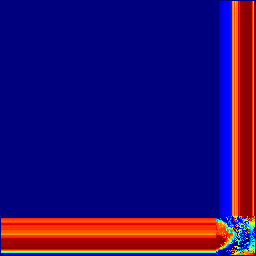

In [16]:
import time

from IPython.display import Image as IPImage
from IPython.display import display
import imageio
import matplotlib.cm as cm
import torch

# NOTE: The following classes/functions must be available:
# - Lenia_C (with Lenia_C.default_config())
# - LeniaInitializationSpace

# Ensure the device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def main(
    SX,
    SY,
    mode="random",
    borders=False,
    list_kernels=range(10),
    creaFile="crea1.pickle",
    modeb="none",
    zoom=1,
):
    # Configure the simulation
    lenia_config = Lenia_C.default_config()
    lenia_config.SX = SX
    lenia_config.SY = SY
    lenia_config.final_step = 200  # number of timesteps
    lenia_config.version = "pytorch_fft"
    lenia_config.nb_kernels = len(list_kernels)

    # Create the initialization space and system
    initialization_space_config = {}  # use a plain dict for simplicity
    initialization_space = LeniaInitializationSpace(
        config=initialization_space_config
    )
    system = Lenia_C(
        initialization_space=initialization_space,
        config=lenia_config,
        device=device,
    )

    # Load initial configuration from file
    a = torch.load(creaFile, map_location=device)
    policy_parameters = {}
    policy_parameters["initialization"] = a["policy_parameters"][
        "initialization"
    ]
    policy_parameters["update_rule"] = a["policy_parameters"]["update_rule"]
    policy_parameters["update_rule"]["R"] = (
        policy_parameters["update_rule"]["R"] + 15
    ) * zoom - 15

    # For each update rule parameter (except R and T), select the desired kernels and move them to device
    for k in policy_parameters["update_rule"].keys():
        if k not in ["R", "T"]:
            policy_parameters["update_rule"][k] = policy_parameters[
                "update_rule"
            ][k][list_kernels]
        policy_parameters["update_rule"][k] = policy_parameters["update_rule"][
            k
        ].to(device)

    # Prepare the initial state image from the initialization parameters
    init_s = (
        policy_parameters["initialization"]
        .init.cpu()
        .numpy()
        .astype(np.float32)
    )
    width = int(init_s.shape[1] * zoom)
    height = int(init_s.shape[0] * zoom)
    # Resize image using OpenCV (note: cv2.resize expects (width, height))
    init_f = cv2.resize(init_s, (width, height))
    init_f = torch.tensor(init_f).to(device)

    # Reset the system with the loaded parameters
    system.reset(
        initialization_parameters=policy_parameters["initialization"],
        update_rule_parameters=policy_parameters["update_rule"],
    )

    # In random mode, add obstacles automatically (no interactive drawing)
    if mode == "random":
        system.random_obstacle()

    # Optionally add border walls
    if borders:
        system.init_wall[:, :4] = 1
        system.init_wall[:, -4:] = 1
        system.init_wall[-4:, :] = 1
        system.init_wall[:4, :] = 1

    system.init_loca = []
    for i in range(1, SX - 40):
        for j in range(1, SY - 40):
            system.init_loca.append((i, j))

    print("Running Lenia simulation...")
    t0 = time.time()
    with torch.no_grad():
        system.generate_init_state()
        # Insert the initial configuration image into the simulation state
        for loca in system.init_loca:
            x, y = loca
            system.state[
                0, x : x + init_f.shape[0], y : y + init_f.shape[1], 0
            ] = init_f
        observations = system.run()
    sim_time = time.time() - t0
    print(f"Simulation completed in {sim_time:.2f} seconds.")

    # Create a GIF from the simulation observations.
    cmap = cm.get_cmap("jet")
    fps = 30.0  # Frames per second for the GIF
    frames = []
    for t in range(observations["states"].shape[0]):
        # Extract the first channel of the state at timestep t
        state = observations["states"][t, :, :, 0].detach().cpu().numpy()
        # Normalize the state to [0, 1]
        norm_state = (state - state.min()) / (state.max() - state.min() + 1e-8)
        # Apply colormap and convert to an 8-bit RGB image
        rgb_frame = (cmap(norm_state)[:, :, :3] * 255).astype(np.uint8)
        frames.append(rgb_frame)

    gif_filename = "out.gif"
    imageio.mimsave(gif_filename, frames, fps=fps)

    # Display the GIF inline in the notebook
    display(IPImage(filename=gif_filename))


# Run the simulation with chosen parameters
SX = 256
SY = 256
mode = "random"  # non-interactive mode
modeb = "none"
borders = False
creature = (
    "crea2"  # filename (without extension) for the initial configuration
)
main(
    SX,
    SY,
    mode,
    borders,
    list(range(10)),
    creaFile=creature + ".pickle",
    modeb=modeb,
    zoom=1,
)
